<a href="https://colab.research.google.com/github/wittyicon29/Convolutional-Network-GAN-/blob/main/DL_GAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np 
import matplotlib.pyplot as plt

Configurations

In [ ]:
device = 'cuda'
batch_size = 128
noise_dim = 64

#optimizers
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#training parameters 
epochs = 20

Datasets

In [ ]:
from torchvision import datasets , transforms as t

train_augs = t.Compose([
                         t.RandomRotation((-30,+30)),
                         t.ToTensor()
])

In [ ]:

#loading datasets
train_set = datasets.MNIST('MNIST/',download = True , train = True , transform = train_augs )

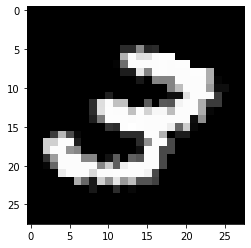

In [ ]:
#displaying data images
image , label = train_set[7]
plt.imshow(image.squeeze() , cmap = 'gray')

In [ ]:
print("Total images in training set: ",len(train_set))

Total images in training set:  60000


In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
train_loader = DataLoader(train_set , batch_size = batch_size , shuffle = True)

#total batches 
print("Total batches : ", len(train_loader))

Total batches :  469


In [ ]:
dataiter = iter(train_loader)
images,_ = dataiter.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
def show_tensor_images(tensor_img, num_img = 16 , size = (1,28,28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img],nrow=4)
    plt.imshow(img_grid.permute(1,2,0).squeeze()) 
    plt.show()

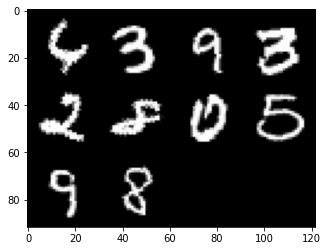

In [ ]:
show_tensor_images(images, num_img =10)

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
def get_disc_blocks(in_channels,out_channels , kernel_size, stride):
    return nn.Sequential(
           nn.Conv2d(in_channels,out_channels,kernel_size,stride),
           nn.BatchNorm2d(out_channels),
           nn.LeakyReLU(0.2)
)

In [ ]:
class Discriminator(nn.Module):
       
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block1 = get_disc_blocks(1,16,(3,3),2)
    self.block2 = get_disc_blocks(16,32,(5,5),2)
    self.block3 = get_disc_blocks(32,64,(5,5),2)

    self.Flatten = nn.Flatten()
    self.Linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self,images):
         
    x1 = self.block1(images)
    x2 = self.block2(x1)
    x3 = self.block3(x2)

    x4 = self.Flatten(x3)
    x5 = self.Linear(x4)

    return x5

In [ ]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

Generator

In [ ]:
def get_gen_block(in_channels , out_channels, kernel_size, stride , final_block = False):
    if final_block == True :
       return nn.Sequential(
                 nn.ConvTranspose2d(in_channels , out_channels , kernel_size , stride),
                 nn.Tanh()
)
    return nn.Sequential(
                nn.ConvTranspose2d(in_channels , out_channels , kernel_size , stride),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
)

In [ ]:
class Generator(nn.Module):
      def __init__(self,noise_dim):
        super(Generator , self).__init__()
 
        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256 , (3,3) , 2)
        self.block_2 = get_gen_block(256, 128 , (4,4) , 1)
        self.block_3 = get_gen_block(128, 64 , (3,3), 2)

        self.block_4 = get_gen_block(64, 1 , (4,4) , 2, final_block = True)
     
      def forward(self , r_noise_vec):
         
        x = r_noise_vec.view(-1, self.noise_dim , 1 , 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
def weights__init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
     nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m , nn.BatchNorm2d):
     nn.init.normal_(m.weight , 0.0,0.02)
     nn.init.constant_(m.bias , 0)

In [ ]:
D = D.apply(weights__init)
G = G.apply(weights__init)

In [ ]:

def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred , ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred , ground_truth)
    return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = learning_rate , betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = learning_rate , betas = (beta_1 ,beta_2))

In [ ]:
from tqdm import tqdm

In [ ]:


for i in range(epochs):
    
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(train_loader):

        real_img = real_img.to(device)
        noise = torch.randn(batch_size , noise_dim, device = device)

        D_opt.zero_grad()
        
        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss)/2
        total_d_loss += D_loss.item()

        D_loss.backward()
        D_opt.step()


        
        G_opt.zero_grad()
        noise = torch.randn(batch_size ,noise_dim, device = device)

        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

        avg_d_loss = total_d_loss/len(train_loader)
        avg_g_loss = total_g_loss/len(train_loader)

        print("Epoch : {} | D_loss : {} | G_loss : {} ".format(i+1, avg_d_loss , avg_g_loss))
         
        show_tensor_images(fake_img)